# Feature Engineering

### Data Encoding

In [13]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

data = pd.read_csv('integrated_data.csv')

# Label Encoding for high cardinality and non-ordinal categorical values
label_encoder = LabelEncoder()
data['SENDER_ACCOUNT_ID'] = label_encoder.fit_transform(data['SENDER_ACCOUNT_ID'])
data['RECEIVER_ACCOUNT_ID'] = label_encoder.fit_transform(data['RECEIVER_ACCOUNT_ID'])

# Binary Encoding for IS_FRAUD
data['IS_FRAUD'] = data['IS_FRAUD'].astype(int)

# One-Hot Encoding for ALERT_TYPE
data = pd.get_dummies(data, columns=['ALERT_TYPE'], drop_first=True)

In [14]:
data

,Unnamed: 0,SENDER_ACCOUNT_ID,RECEIVER_ACCOUNT_ID,INIT_BALANCE,TX_BEHAVIOR_ID,TX_AMOUNT,TIMESTAMP,IS_FRAUD,ALERT_ID,ALERT_TYPE_cycle,ALERT_TYPE_fan_in
0,0,0,17405,-0.471509,1,-0.065497,1,0,-1,0,0
1,1,0,17405,-0.471509,1,-0.065497,30,0,-1,0,0
2,2,0,17405,-0.471509,1,-0.065497,37,0,-1,0,0
3,3,0,17405,-0.471509,1,-0.065497,47,0,-1,0,0
4,4,0,17405,-0.471509,1,-0.065497,49,0,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
12476007,12476007,99999,71940,0.802459,5,-0.064895,194,0,-1,0,0
12476008,12476008,99999,92113,0.802459,5,-0.064895,194,0,-1,0,0
12476009,12476009,99999,18923,0.802459,5,-0.064895,194,0,-1,0,0
12476010,12476010,99999,45349,0.802459,5,-0.064895,194,0,-1,0,0


In [15]:
data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [16]:
data.to_csv('processed_data.csv', index=False)

### RFM Principle

In [17]:
import pandas as pd
import numpy as np
import scipy.stats as stats

data = pd.read_csv('processed_data.csv')

# Calculate Recency: time difference between successive transactions for each sender account
data['RECENCY'] = data.groupby('SENDER_ACCOUNT_ID')['TIMESTAMP'].diff().fillna(0)

# Calculate Frequency: determine total number of transactions for each sender account
data['FREQUENCY'] = data.groupby('SENDER_ACCOUNT_ID')['TIMESTAMP'].transform('count')

# Calculate Monetary: compute total monetary value of transactions for each sender account
data['MONETARY'] = data.groupby('SENDER_ACCOUNT_ID')['TX_AMOUNT'].transform('sum')

In [2]:
data

,SENDER_ACCOUNT_ID,RECEIVER_ACCOUNT_ID,INIT_BALANCE,TX_BEHAVIOR_ID,TX_AMOUNT,TIMESTAMP,IS_FRAUD,ALERT_ID,ALERT_TYPE_cycle,ALERT_TYPE_fan_in,RECENCY,FREQUENCY,MONETARY
0,0,17405,-0.471509,1,-0.065497,1,0,-1,0,0,0.0,20,-1.309932
1,0,17405,-0.471509,1,-0.065497,30,0,-1,0,0,29.0,20,-1.309932
2,0,17405,-0.471509,1,-0.065497,37,0,-1,0,0,7.0,20,-1.309932
3,0,17405,-0.471509,1,-0.065497,47,0,-1,0,0,10.0,20,-1.309932
4,0,17405,-0.471509,1,-0.065497,49,0,-1,0,0,2.0,20,-1.309932
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12476007,99999,71940,0.802459,5,-0.064895,194,0,-1,0,0,10.0,85,-5.516036
12476008,99999,92113,0.802459,5,-0.064895,194,0,-1,0,0,0.0,85,-5.516036
12476009,99999,18923,0.802459,5,-0.064895,194,0,-1,0,0,0.0,85,-5.516036
12476010,99999,45349,0.802459,5,-0.064895,194,0,-1,0,0,0.0,85,-5.516036


In [18]:
data.to_csv('processed_data.csv', index=False)

In [14]:
#Dividing the data to shorten running time
subset_size = 250000
subsets = [data.iloc[i:i + subset_size] for i in range(0, data.shape[0], subset_size)]

# Save each subset as a separate file
for i, subset in enumerate(subsets):
    subset.to_csv(f'subset_{i}.csv', index=False)

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from dask import dataframe as dd
from dask.distributed import Client

# Initialize a Dask cluster to help with computation
client = Client(n_workers=8, threads_per_worker=2, memory_limit='2GB')

# Function to fit von Mises distribution
def von_mises_params(timestamps):
    timestamps = np.array(timestamps)
    kappa, loc, scale = stats.vonmises.fit(timestamps)[:3]
    return kappa, loc, scale

# Group by SENDER_ACCOUNT_ID and apply the function
def apply_von_mises(group):
    kappa, loc, scale = von_mises_params(group['TIMESTAMP'].values)
    group['KAPPA'] = kappa
    group['LOC'] = loc
    group['SCALE'] = scale
    return group

# Process each subset file
def process_subset(filename):
    subset = pd.read_csv(filename)
    subset_ddf = dd.from_pandas(subset, npartitions=4)
    meta = subset.head(0)
    meta['KAPPA'] = np.float64
    meta['LOC'] = np.float64
    meta['SCALE'] = np.float64
    subset_ddf = subset_ddf.groupby('SENDER_ACCOUNT_ID').apply(apply_von_mises, meta=meta)
    processed_subset = subset_ddf.compute()
    processed_subset.to_csv(f'processed_{filename}', index=False)

In [ ]:
# Process all subset files one by one and save them immediately
subset_files = [f for f in os.listdir('.') if f.startswith('subset_') and f.endswith('.csv')]

for subset_file in subset_files:
    processed_file = f'processed_{subset_file}'
    if not os.path.exists(processed_file):
        print(f"Processing {subset_file}")
        process_subset(subset_file)
        print(f"Saved {processed_file}")
    else:
        print(f"Skipping {subset_file}, already processed.")

In [9]:
def process_batch(batch_files):
    batch_dfs = []
    for filename in batch_files:
        subset = pd.read_csv(filename)
        batch_dfs.append(subset)
    combined_df = pd.concat(batch_dfs)
    combined_df.to_csv('combined_batch.csv', index=False)

# List all processed CSV files
processed_files = [f for f in os.listdir('.') if f.startswith('processed_subset_') and f.endswith('.csv')]

# Define batch size
batch_size = 5

# Process files in batches
for i in range(0, len(processed_files), batch_size):
    batch_files = processed_files[i:i + batch_size]
    process_batch(batch_files)

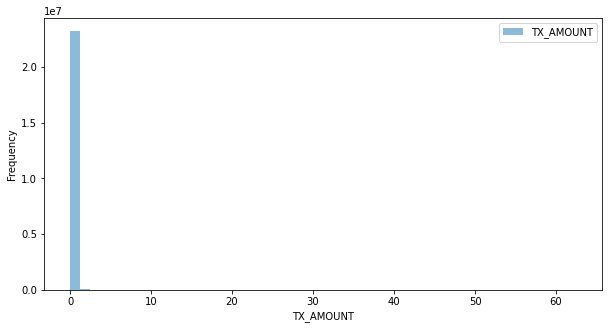

True     18736990
False     4605286
Name: IS_ATYPICAL, dtype: int64
False    23149874
True       192402
Name: IS_ATYPICAL, dtype: int64


In [20]:
import matplotlib.pyplot as plt  

# Read the existing CSV file
data = pd.read_csv('processed_data.csv')

# Read the combined batch CSV file
combined_processed_data = pd.read_csv('combined_batch.csv')

# Merge the processed data with the original data
data = data.merge(combined_processed_data[['SENDER_ACCOUNT_ID', 'TIMESTAMP', 'KAPPA', 'LOC', 'SCALE']], on=['SENDER_ACCOUNT_ID', 'TIMESTAMP'], how='left')

# Visualize the distributions before flagging
plt.figure(figsize=(10, 5))
plt.hist(data['TX_AMOUNT'], bins=50, alpha=0.5, label='TX_AMOUNT')
plt.xlabel('TX_AMOUNT')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Flag transactions as atypical using von Mises distribution
def flag_atypical(row):
    kappa = row['KAPPA']
    loc = row['LOC']
    scale = row['SCALE']
    return not stats.vonmises(loc, kappa, scale).pdf(row['TIMESTAMP']) > 0.05

data['IS_ATYPICAL'] = data.apply(flag_atypical, axis=1)

# Check the distribution of IS_ATYPICAL
print(data['IS_ATYPICAL'].value_counts())

# Adjusted function to flag atypical transactions with a different threshold
def flag_atypical_adjusted(transaction_amount, median, mad, threshold_multiplier=3):
    threshold = threshold_multiplier * mad
    return (transaction_amount > (median + threshold)) | (transaction_amount < (median - threshold))

# Recalculate is_atypical with a different threshold multiplier
data['median'] = data.groupby('SENDER_ACCOUNT_ID')['TX_AMOUNT'].transform(lambda x: x.rolling(window=7).median())
data['mad'] = data.groupby('SENDER_ACCOUNT_ID')['TX_AMOUNT'].transform(lambda x: x.rolling(window=7).apply(lambda y: np.median(np.abs(y - np.median(y))), raw=True))

data['IS_ATYPICAL'] = data.apply(lambda row: flag_atypical_adjusted(row['TX_AMOUNT'], row['median'], row['mad'], threshold_multiplier=2.5), axis=1)

# Check the new distribution of IS_ATYPICAL
print(data['IS_ATYPICAL'].value_counts())

# Save the final result
data.to_csv('processed_data.csv', index=False)

In [21]:
data

,SENDER_ACCOUNT_ID,RECEIVER_ACCOUNT_ID,INIT_BALANCE,TX_BEHAVIOR_ID,TX_AMOUNT,TIMESTAMP,IS_FRAUD,ALERT_ID,ALERT_TYPE_cycle,ALERT_TYPE_fan_in,RECENCY,FREQUENCY,MONETARY,KAPPA,LOC,SCALE,IS_ATYPICAL,median,mad
0,0,17405,-0.471509,1,-0.065497,1,0,-1,0,0,0.0,20,-1.309932,NaN,NaN,NaN,False,NaN,NaN
1,0,17405,-0.471509,1,-0.065497,30,0,-1,0,0,29.0,20,-1.309932,NaN,NaN,NaN,False,NaN,NaN
2,0,17405,-0.471509,1,-0.065497,37,0,-1,0,0,7.0,20,-1.309932,NaN,NaN,NaN,False,NaN,NaN
3,0,17405,-0.471509,1,-0.065497,47,0,-1,0,0,10.0,20,-1.309932,NaN,NaN,NaN,False,NaN,NaN
4,0,17405,-0.471509,1,-0.065497,49,0,-1,0,0,2.0,20,-1.309932,NaN,NaN,NaN,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23342271,99999,71940,0.802459,5,-0.064895,194,0,-1,0,0,10.0,85,-5.516036,NaN,NaN,NaN,False,-0.064895,0.0
23342272,99999,92113,0.802459,5,-0.064895,194,0,-1,0,0,0.0,85,-5.516036,NaN,NaN,NaN,False,-0.064895,0.0
23342273,99999,18923,0.802459,5,-0.064895,194,0,-1,0,0,0.0,85,-5.516036,NaN,NaN,NaN,False,-0.064895,0.0
23342274,99999,45349,0.802459,5,-0.064895,194,0,-1,0,0,0.0,85,-5.516036,NaN,NaN,NaN,False,-0.064895,0.0


### Analyzing IS_ATYPICAL

In [52]:
#Filter atypical transactions
atypical_transactions = data[data['IS_ATYPICAL']]

#Summary statistics
summary_stats = atypical_transactions.describe()
summary_stats

,SENDER_ACCOUNT_ID,RECEIVER_ACCOUNT_ID,INIT_BALANCE,TX_BEHAVIOR_ID,TX_AMOUNT,TIMESTAMP,IS_FRAUD,ALERT_ID,ALERT_TYPE_cycle,ALERT_TYPE_fan_in,RECENCY,FREQUENCY,MONETARY,KAPPA,LOC,SCALE,median,mad,CONNECTED_ACCOUNTS
count,192402.000000,192402.000000,192402.000000,192402.000000,192402.000000,192402.000000,192402.000000,192402.000000,192402.000000,192402.000000,192402.000000,192402.000000,192402.000000,19637.000000,19637.000000,1.963700e+04,192402.000000,192402.000000,192402.000000
mean,48291.950323,49689.052058,0.232761,2.075888,2.935065,128.334721,0.071174,149.347366,0.039573,0.031601,11.011377,36.385303,37.908080,0.433815,126.222790,3.337007e-02,0.681350,0.287367,15.572328
std,28802.755036,28556.648737,0.428913,0.466000,6.284293,43.770110,0.257116,623.764854,0.194955,0.174934,9.292547,98.581534,43.499353,0.469173,187.365701,8.174212e-01,1.595649,0.594673,8.861304
min,13.000000,1.000000,-0.992574,1.000000,-0.066035,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,7.000000,-192.612026,0.000150,-7061.072710,1.201817e-34,-0.066035,0.000000,1.000000
25%,23053.000000,25059.250000,-0.100580,2.000000,0.124795,94.000000,0.000000,-1.000000,0.000000,0.000000,3.000000,19.000000,15.841358,0.045493,81.911849,6.647984e-30,-0.017605,0.013187,10.000000
50%,51149.000000,49745.000000,0.233446,2.000000,0.732003,131.000000,0.000000,-1.000000,0.000000,0.000000,9.000000,21.000000,29.274570,0.248215,143.873638,2.537686e-27,0.142216,0.067857,13.000000
75%,73110.000000,74434.750000,0.560747,2.000000,3.035349,166.000000,0.000000,-1.000000,0.000000,0.000000,16.000000,24.000000,48.301326,0.839671,176.073249,1.979988e-26,0.735469,0.287804,19.000000
max,99998.000000,99068.000000,2.092347,5.000000,62.562056,199.000000,1.000000,3999.000000,1.000000,1.000000,109.000000,2917.000000,1119.500233,2.863712,691.257698,2.198236e+01,62.562056,16.770375,134.000000


**Transaction Amounts:**

Mean TX_AMOUNT is 2.935.
Standard deviation is 6.284, indicating a high variance.
Minimum and maximum values are -0.066 and 62.562, respectively.
Distribution:

The median (50%) value of TX_AMOUNT is 0.732, which is significantly lower than the mean, suggesting a skewed distribution.

**Fraud:**

Approximately 7.1% of atypical transactions are fraudulent (IS_FRAUD mean of 0.071).

**Timestamps:**

The mean TIMESTAMP is 128.334, with a wide range from 1 to 199.

**Von Mises Parameters:**

KAPPA, LOC, and SCALE values are provided for a subset of transactions (19,637 out of 192,402).

#### Fraud

In [53]:
# Overall fraud rate
overall_fraud_rate = data['IS_FRAUD'].mean()

# Fraud rate among atypical transactions
atypical_fraud_rate = atypical_transactions['IS_FRAUD'].mean()

print(f'Overall Fraud Rate: {overall_fraud_rate:.4f}')
print(f'Fraud Rate among Atypical Transactions: {atypical_fraud_rate:.4f}')

Overall Fraud Rate: 0.0008
Fraud Rate among Atypical Transactions: 0.0712


**The process is identifying a subset of transactions with a higher likelihood of fraud.**

In [54]:
# Contingency table of atypical vs fraud
contingency_table = pd.crosstab(data['IS_ATYPICAL'], data['IS_FRAUD'])

# Chi-squared test
chi2, p, dof, ex = stats.chi2_contingency(contingency_table)
print(f'Chi-squared Test: Chi2={chi2}, p-value={p}')

Chi-squared Test: Chi2=1228798.425308585, p-value=0.0


**The Chi-squared test results indicate a very high Chi-squared value and a p-value of 0.0, suggesting a strong association between atypical transactions and fraud.**

#### Analysis of Atypical Fraudulent Transactions

In [56]:
# Filter atypical and fraudulent transactions
atypical_fraud_transactions = atypical_transactions[atypical_transactions['IS_FRAUD'] == 1]

# Summary statistics of atypical fraudulent transactions
atypical_fraud_summary_stats = atypical_fraud_transactions.describe()
atypical_fraud_summary_stats

,SENDER_ACCOUNT_ID,RECEIVER_ACCOUNT_ID,INIT_BALANCE,TX_BEHAVIOR_ID,TX_AMOUNT,TIMESTAMP,IS_FRAUD,ALERT_ID,ALERT_TYPE_cycle,ALERT_TYPE_fan_in,RECENCY,FREQUENCY,MONETARY,KAPPA,LOC,SCALE,median,mad,CONNECTED_ACCOUNTS
count,13694.000000,13694.000000,13694.000000,13694.000000,13694.000000,13694.000000,13694.0,13694.000000,13694.000000,13694.000000,13694.000000,13694.000000,13694.000000,1707.000000,1707.000000,1.707000e+03,13694.000000,13694.000000,13694.000000
mean,51889.052943,49218.154885,0.131940,3.061852,-0.066005,109.612750,1.0,2111.394771,0.556010,0.443990,6.045640,232.978166,-12.547795,0.173629,146.047488,3.935975e-04,0.034564,0.012679,17.132759
std,29165.533306,28497.947517,0.942538,1.407604,0.000018,54.892227,0.0,1149.824695,0.496871,0.496871,6.933601,304.748302,27.410461,0.333614,233.574153,1.544434e-02,1.637209,0.115743,16.570228
min,13.000000,12.000000,-0.992574,1.000000,-0.066027,1.000000,1.0,1.000000,0.000000,0.000000,0.000000,10.000000,-192.612026,0.000150,-6574.993640,1.473402e-33,-0.066032,0.000000,1.000000
25%,26951.250000,24603.500000,-0.669037,2.000000,-0.066023,64.000000,1.0,1129.250000,0.000000,0.000000,1.000000,86.000000,-14.467518,0.045493,160.910878,3.344740e-27,-0.065730,0.000000,7.000000
50%,51953.500000,48524.500000,-0.279010,3.000000,-0.066002,111.000000,1.0,2204.000000,1.000000,0.000000,4.000000,181.000000,-11.682254,0.045493,162.053999,1.281324e-26,-0.065388,0.000000,12.000000
75%,78139.000000,73233.750000,0.956961,4.000000,-0.065989,157.000000,1.0,3094.000000,1.000000,1.000000,8.000000,221.000000,-5.637193,0.045494,162.931602,3.233319e-26,-0.064694,0.000000,20.000000
max,99998.000000,99066.000000,2.092347,5.000000,-0.065976,199.000000,1.0,3999.000000,1.000000,1.000000,67.000000,2917.000000,643.008209,2.316075,446.667043,6.371725e-01,62.562056,6.734331,134.000000


**Transaction Amounts:**

The mean TX_AMOUNT is very close to zero (-0.066), indicating small transaction amounts.
The standard deviation is extremely low (0.000018), suggesting very little variance in transaction amounts.
Timestamps:

The mean TIMESTAMP is 109.613, with a standard deviation of 54.892, indicating a wide range of transaction times.

**Behavior and Balance:**

The mean TX_BEHAVIOR_ID is 3.061, suggesting certain behaviors are more associated with fraudulent transactions.
INIT_BALANCE has a mean of 0.132 with a high standard deviation (0.943), indicating a wide range of initial balances.

**Alert Types:**

ALERT_TYPE_cycle and ALERT_TYPE_fan_in show that both alert types are present with mean values close to 0.556 and 0.444, respectively.

### Analyzing Von Mises

In [59]:
data

,SENDER_ACCOUNT_ID,RECEIVER_ACCOUNT_ID,INIT_BALANCE,TX_BEHAVIOR_ID,TX_AMOUNT,TIMESTAMP,IS_FRAUD,ALERT_ID,ALERT_TYPE_cycle,ALERT_TYPE_fan_in,RECENCY,FREQUENCY,MONETARY,KAPPA,LOC,SCALE,IS_ATYPICAL,median,mad,CONNECTED_ACCOUNTS
0,0,17405,-0.471509,1,-0.065497,1,0,-1,0,0,0.0,20,-1.309932,NaN,NaN,NaN,False,NaN,NaN,2
1,0,17405,-0.471509,1,-0.065497,30,0,-1,0,0,29.0,20,-1.309932,NaN,NaN,NaN,False,NaN,NaN,2
2,0,17405,-0.471509,1,-0.065497,37,0,-1,0,0,7.0,20,-1.309932,NaN,NaN,NaN,False,NaN,NaN,2
3,0,17405,-0.471509,1,-0.065497,47,0,-1,0,0,10.0,20,-1.309932,NaN,NaN,NaN,False,NaN,NaN,2
4,0,17405,-0.471509,1,-0.065497,49,0,-1,0,0,2.0,20,-1.309932,NaN,NaN,NaN,False,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23342271,99999,71940,0.802459,5,-0.064895,194,0,-1,0,0,10.0,85,-5.516036,NaN,NaN,NaN,False,-0.064895,0.0,5
23342272,99999,92113,0.802459,5,-0.064895,194,0,-1,0,0,0.0,85,-5.516036,NaN,NaN,NaN,False,-0.064895,0.0,5
23342273,99999,18923,0.802459,5,-0.064895,194,0,-1,0,0,0.0,85,-5.516036,NaN,NaN,NaN,False,-0.064895,0.0,5
23342274,99999,45349,0.802459,5,-0.064895,194,0,-1,0,0,0.0,85,-5.516036,NaN,NaN,NaN,False,-0.064895,0.0,5


In [26]:
if data[['KAPPA', 'LOC', 'SCALE']].isna().all().all():
    data = data.drop(columns=['KAPPA', 'LOC', 'SCALE'])

In [58]:
# Check proportion of missing values
missing_values_proportion = data[['KAPPA', 'LOC', 'SCALE']].isnull().mean()
print(missing_values_proportion)

KAPPA    0.48093
LOC      0.48093
SCALE    0.48093
dtype: float64


**About half of the values are missing. Doing and evaluation of Feature Importance**

In [61]:
# Drop rows with NaN in KAPPA, LOC, SCALE for this analysis
non_nan_data = data.dropna(subset=['KAPPA', 'LOC', 'SCALE'])

# Check for NaN values
print(non_nan_data[['KAPPA', 'LOC', 'SCALE']].isnull().sum())

# Check for infinite values
print(np.isinf(non_nan_data[['KAPPA', 'LOC', 'SCALE']]).sum())

# Check for extremely large values
print((non_nan_data[['KAPPA', 'LOC', 'SCALE']] > np.finfo(np.float32).max).sum())

KAPPA    0
LOC      0
SCALE    0
dtype: int64
KAPPA    0
LOC      0
SCALE    0
dtype: int64
KAPPA    0
LOC      0
SCALE    0
dtype: int64


In [62]:
# Prepare features and target
features = ['TX_AMOUNT', 'KAPPA', 'LOC', 'SCALE', 'median', 'mad']
X_non_nan = non_nan_data[features]
y_non_nan = non_nan_data['IS_FRAUD']

In [64]:
print(X_non_nan.isnull().sum())
print(y_non_nan.isnull().sum())

TX_AMOUNT        0
KAPPA            0
LOC              0
SCALE            0
median       50004
mad          50004
dtype: int64
0


In [66]:
# Replace infinite values with NaN
X_non_nan.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values in 'median' and 'mad' with the column mean
X_non_nan['median'].fillna(X_non_nan['median'].mean(), inplace=True)
X_non_nan['mad'].fillna(X_non_nan['mad'].mean(), inplace=True)

# Replace extremely large values with the maximum finite value of the column
max_finite_value = X_non_nan['median'][np.isfinite(X_non_nan['median'])].max()
X_non_nan['median'] = np.where(X_non_nan['median'] > np.finfo(np.float32).max, max_finite_value, X_non_nan['median'])

max_finite_value = X_non_nan['mad'][np.isfinite(X_non_nan['mad'])].max()
X_non_nan['mad'] = np.where(X_non_nan['mad'] > np.finfo(np.float32).max, max_finite_value, X_non_nan['mad'])

# Check for NaN values
print("NaN values: ", X_non_nan.isnull().sum())

# Check for infinite values
print("Infinite values ", np.isinf(X_non_nan).sum())

# Check for extremely large values
print(("extremely large values: ", X_non_nan > np.finfo(np.float32).max).sum())

/var/folders/bh/2l7hg4qn0xnfpz15rkf1t3h80000gn/T/ipykernel_11614/1185692189.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_non_nan.replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/bh/2l7hg4qn0xnfpz15rkf1t3h80000gn/T/ipykernel_11614/1185692189.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_non_nan['median'].fillna(X_non_nan['median'].mean(), inplace=True)
/var/folders/bh/2l7hg4qn0xnfpz15rkf1t3h80000gn/T/ipykernel_11614/1185692189.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

TX_AMOUNT    0
KAPPA        0
LOC          0
SCALE        0
median       0
mad          0
dtype: int64
TX_AMOUNT    0
KAPPA        0
LOC          0
SCALE        0
median       0
mad          0
dtype: int64
TX_AMOUNT    0
KAPPA        0
LOC          0
SCALE        0
median       0
mad          0
dtype: int64


In [67]:
# Train a Random Forest classifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Split the data into train and test sets
X_train_non_nan, X_test_non_nan, y_train_non_nan, y_test_non_nan = train_test_split(X_non_nan, y_non_nan, test_size=0.3, random_state=42)

# Initialize and train the classifier
clf_non_nan = RandomForestClassifier(n_estimators=100, random_state=42)
clf_non_nan.fit(X_train_non_nan, y_train_non_nan)

RandomForestClassifier(random_state=42)

TX_AMOUNT    0.395860
median       0.332673
LOC          0.113501
KAPPA        0.087140
mad          0.070312
SCALE        0.000514
dtype: float64


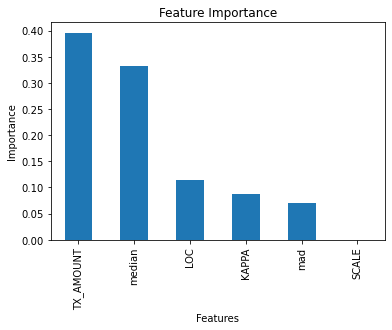

In [68]:
# Feature importance
feature_importance_non_nan = pd.Series(clf_non_nan.feature_importances_, index=features).sort_values(ascending=False)
print(feature_importance_non_nan)

# Plot feature importance
import matplotlib.pyplot as plt
feature_importance_non_nan.plot(kind='bar')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

**Dropping SCALE because of low importance**

In [4]:
data.drop(['SCALE'], axis=1, inplace=True)

#### Implementing K-Nearest Neighbors (KNN) Imputation to fill in NaNs

Why KNN Imputation?

Data Patterns: KNN imputation considers the patterns and relationships within the dataset by using the nearest neighbors to fill in missing values. This can be particularly useful in financial data where certain patterns and correlations might exist.
Flexibility: It doesn’t assume a linear relationship between variables, making it suitable for complex datasets.
Robustness: KNN can handle outliers better than mean/median imputation, which might skew the data if outliers are present.

In [2]:
import pandas as pd

data = pd.read_csv('processed_data.csv')

In [3]:
data

,SENDER_ACCOUNT_ID,RECEIVER_ACCOUNT_ID,INIT_BALANCE,TX_BEHAVIOR_ID,TX_AMOUNT,TIMESTAMP,IS_FRAUD,ALERT_ID,ALERT_TYPE_cycle,ALERT_TYPE_fan_in,RECENCY,FREQUENCY,MONETARY,KAPPA,LOC,SCALE,IS_ATYPICAL,median,mad
0,0,17405,-0.471509,1,-0.065497,1,0,-1,0,0,0.0,20,-1.309932,NaN,NaN,NaN,False,NaN,NaN
1,0,17405,-0.471509,1,-0.065497,30,0,-1,0,0,29.0,20,-1.309932,NaN,NaN,NaN,False,NaN,NaN
2,0,17405,-0.471509,1,-0.065497,37,0,-1,0,0,7.0,20,-1.309932,NaN,NaN,NaN,False,NaN,NaN
3,0,17405,-0.471509,1,-0.065497,47,0,-1,0,0,10.0,20,-1.309932,NaN,NaN,NaN,False,NaN,NaN
4,0,17405,-0.471509,1,-0.065497,49,0,-1,0,0,2.0,20,-1.309932,NaN,NaN,NaN,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23342271,99999,71940,0.802459,5,-0.064895,194,0,-1,0,0,10.0,85,-5.516036,NaN,NaN,NaN,False,-0.064895,0.0
23342272,99999,92113,0.802459,5,-0.064895,194,0,-1,0,0,0.0,85,-5.516036,NaN,NaN,NaN,False,-0.064895,0.0
23342273,99999,18923,0.802459,5,-0.064895,194,0,-1,0,0,0.0,85,-5.516036,NaN,NaN,NaN,False,-0.064895,0.0
23342274,99999,45349,0.802459,5,-0.064895,194,0,-1,0,0,0.0,85,-5.516036,NaN,NaN,NaN,False,-0.064895,0.0


In [6]:
import numpy as np

# Replace infinite values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [17]:
import sklearn
print("scikit-learn version:", sklearn.__version__)

scikit-learn version: 1.5.0


In [ ]:
from sklearn.impute import KNNImputer
import pandas as pd

# Sample a smaller subset of the data
subset = data.sample(frac=0.05, random_state=42)  # Adjust the fraction as needed
print("Sampled smaller subset of data")

# Initialize the KNN imputer with a suitable number of neighbors
imputer = KNNImputer(n_neighbors=5)
print("Initialized KNN Imputer")

# Apply the imputer to the subset
print("Starting KNN imputation...")
subset_imputed = subset.copy()
subset_imputed[['KAPPA', 'LOC', 'median', 'mad']] = imputer.fit_transform(subset[['KAPPA', 'LOC', 'median', 'mad']])
print("KNN imputation completed")

# Merge the imputed subset back into the original data
data.update(subset_imputed)
print("Updated original data with imputed subset")

# Verify there are no NaN values left in the imputed columns
print("Remaining NaN values in the imputed columns:")
print(data[['KAPPA', 'LOC', 'median', 'mad']].isnull().sum())

Sampled smaller subset of data
Initialized KNN Imputer
Starting KNN imputation...


In [74]:
# Replace extremely large values with the maximum finite value of the column
max_finite_value_median = data['median'][np.isfinite(data['median'])].max()
data['median'] = np.where(data['median'] > np.finfo(np.float32).max, max_finite_value_median, data['median'])

max_finite_value_mad = data['mad'][np.isfinite(data['mad'])].max()
data['mad'] = np.where(data['mad'] > np.finfo(np.float32).max, max_finite_value_mad, data['mad'])

In [76]:
data

,SENDER_ACCOUNT_ID,RECEIVER_ACCOUNT_ID,INIT_BALANCE,TX_BEHAVIOR_ID,TX_AMOUNT,TIMESTAMP,IS_FRAUD,ALERT_ID,ALERT_TYPE_cycle,ALERT_TYPE_fan_in,RECENCY,FREQUENCY,MONETARY,KAPPA,LOC,IS_ATYPICAL,median,mad,CONNECTED_ACCOUNTS
0,0.0,17405.0,-0.471509,1.0,-0.065497,1.0,0.0,-1.0,0.0,0.0,0.0,20.0,-1.309932,NaN,NaN,0.0,NaN,NaN,2.0
1,0.0,17405.0,-0.471509,1.0,-0.065497,30.0,0.0,-1.0,0.0,0.0,29.0,20.0,-1.309932,NaN,NaN,0.0,NaN,NaN,2.0
2,0.0,17405.0,-0.471509,1.0,-0.065497,37.0,0.0,-1.0,0.0,0.0,7.0,20.0,-1.309932,NaN,NaN,0.0,NaN,NaN,2.0
3,0.0,17405.0,-0.471509,1.0,-0.065497,47.0,0.0,-1.0,0.0,0.0,10.0,20.0,-1.309932,NaN,NaN,0.0,NaN,NaN,2.0
4,0.0,17405.0,-0.471509,1.0,-0.065497,49.0,0.0,-1.0,0.0,0.0,2.0,20.0,-1.309932,NaN,NaN,0.0,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23342271,99999.0,71940.0,0.802459,5.0,-0.064895,194.0,0.0,-1.0,0.0,0.0,10.0,85.0,-5.516036,0.045493,162.37504,0.0,-0.064895,0.0,5.0
23342272,99999.0,92113.0,0.802459,5.0,-0.064895,194.0,0.0,-1.0,0.0,0.0,0.0,85.0,-5.516036,NaN,NaN,0.0,-0.064895,0.0,5.0
23342273,99999.0,18923.0,0.802459,5.0,-0.064895,194.0,0.0,-1.0,0.0,0.0,0.0,85.0,-5.516036,NaN,NaN,0.0,-0.064895,0.0,5.0
23342274,99999.0,45349.0,0.802459,5.0,-0.064895,194.0,0.0,-1.0,0.0,0.0,0.0,85.0,-5.516036,NaN,NaN,0.0,-0.064895,0.0,5.0


In [75]:
# Check for any remaining NaN values
print("NaN values: ", data[['KAPPA', 'LOC', 'median', 'mad']].isnull().sum())

# Check for any remaining infinite values
print("Infinite values: ", np.isinf(data[['KAPPA', 'LOC', 'median', 'mad']]).sum())

# Check for any remaining extremely large values
print(("Extremely large values: ", data[['KAPPA', 'LOC', 'median', 'mad']] > np.finfo(np.float32).max).sum())

NaN values:  KAPPA     10103671
LOC       10103671
median      540137
mad         540137
dtype: int64
Infinite values:  KAPPA     0
LOC       0
median    0
mad       0
dtype: int64


AttributeError: 'tuple' object has no attribute 'sum'

In [ ]:
data.to_csv('processed_data.csv', index=False)

### Analyzing RFM

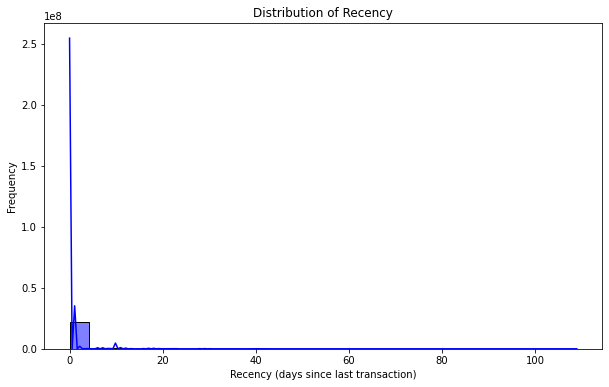

In [32]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(data['RECENCY'], kde=True, color='blue')
plt.title('Distribution of Recency')
plt.xlabel('Recency (days since last transaction)')
plt.ylabel('Frequency')
plt.show()

The large spike at the beginning of the plot indicates a high number of transactions with very low recency values: many transactions occured very recently.

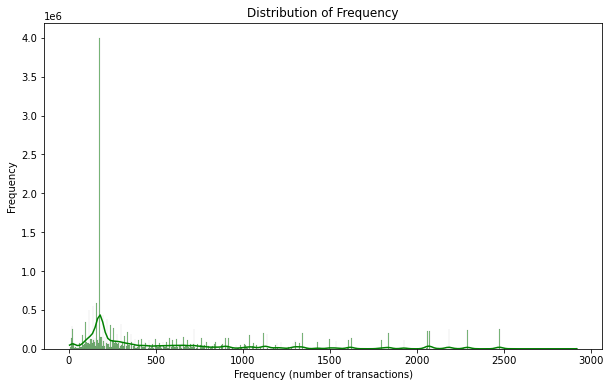

In [33]:
plt.figure(figsize=(10, 6))
sns.histplot(data['FREQUENCY'], kde=True, color='green')
plt.title('Distribution of Frequency')
plt.xlabel('Frequency (number of transactions)')
plt.ylabel('Frequency')
plt.show()

The initial high peak indicates that for many accounts, most transactions occur infrequently. The long tail extending towards higher frequency has much lower counts, suggesting that a small number of accounts have hig transaction frequency.

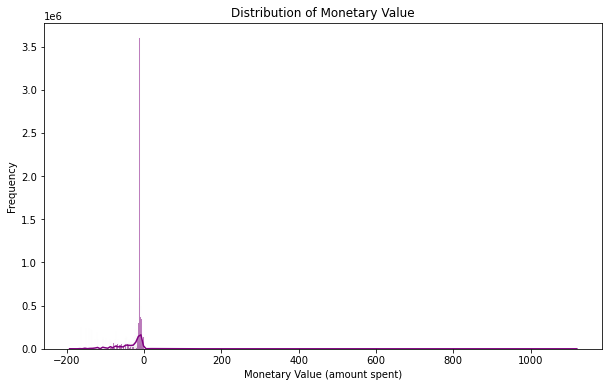

In [34]:
plt.figure(figsize=(10, 6))
sns.histplot(data['MONETARY'], kde=True, color='purple')
plt.title('Distribution of Monetary Value')
plt.xlabel('Monetary Value (amount spent)')
plt.ylabel('Frequency')
plt.show()

The high peak indicates that must transactions involve smaller monetary values. 

### Network Connvectivity

In [47]:
data = pd.read_csv('processed_data.csv')

In [48]:
data

,SENDER_ACCOUNT_ID,RECEIVER_ACCOUNT_ID,INIT_BALANCE,TX_BEHAVIOR_ID,TX_AMOUNT,TIMESTAMP,IS_FRAUD,ALERT_ID,ALERT_TYPE_cycle,ALERT_TYPE_fan_in,RECENCY,FREQUENCY,MONETARY,KAPPA,LOC,SCALE,IS_ATYPICAL,median,mad
0,0,17405,-0.471509,1,-0.065497,1,0,-1,0,0,0.0,20,-1.309932,NaN,NaN,NaN,False,NaN,NaN
1,0,17405,-0.471509,1,-0.065497,30,0,-1,0,0,29.0,20,-1.309932,NaN,NaN,NaN,False,NaN,NaN
2,0,17405,-0.471509,1,-0.065497,37,0,-1,0,0,7.0,20,-1.309932,NaN,NaN,NaN,False,NaN,NaN
3,0,17405,-0.471509,1,-0.065497,47,0,-1,0,0,10.0,20,-1.309932,NaN,NaN,NaN,False,NaN,NaN
4,0,17405,-0.471509,1,-0.065497,49,0,-1,0,0,2.0,20,-1.309932,NaN,NaN,NaN,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23342271,99999,71940,0.802459,5,-0.064895,194,0,-1,0,0,10.0,85,-5.516036,NaN,NaN,NaN,False,-0.064895,0.0
23342272,99999,92113,0.802459,5,-0.064895,194,0,-1,0,0,0.0,85,-5.516036,NaN,NaN,NaN,False,-0.064895,0.0
23342273,99999,18923,0.802459,5,-0.064895,194,0,-1,0,0,0.0,85,-5.516036,NaN,NaN,NaN,False,-0.064895,0.0
23342274,99999,45349,0.802459,5,-0.064895,194,0,-1,0,0,0.0,85,-5.516036,NaN,NaN,NaN,False,-0.064895,0.0


In [49]:
import networkx as nx

# Create graph from transaction data
G = nx.from_pandas_edgelist(data, 'SENDER_ACCOUNT_ID', 'RECEIVER_ACCOUNT_ID', ['TX_AMOUNT'])

# Number of unique connected accounts
data['CONNECTED_ACCOUNTS'] = data['SENDER_ACCOUNT_ID'].apply(lambda x: len(list(G.neighbors(x))))

# Clustering coefficient: measure of the degree to which nodes in a graph tend to cluster together
data['CLUSTERING_COEFFICIENT'] = data['SENDER_ACCOUNT_ID'].apply(lambda x: nx.clustering(G, x))

KeyboardInterrupt: 

In [ ]:
data.to_csv('processed_data.csv', index=False)

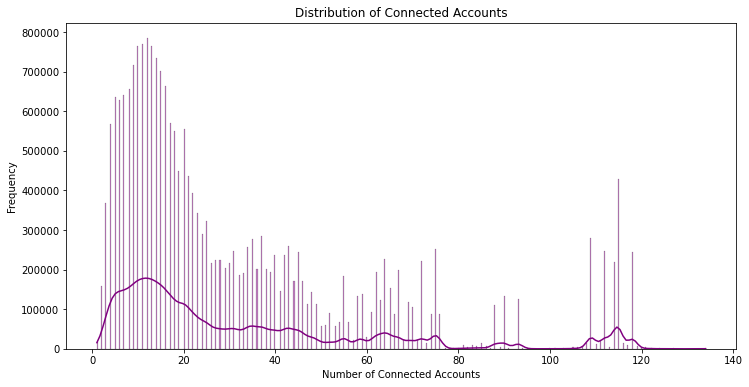

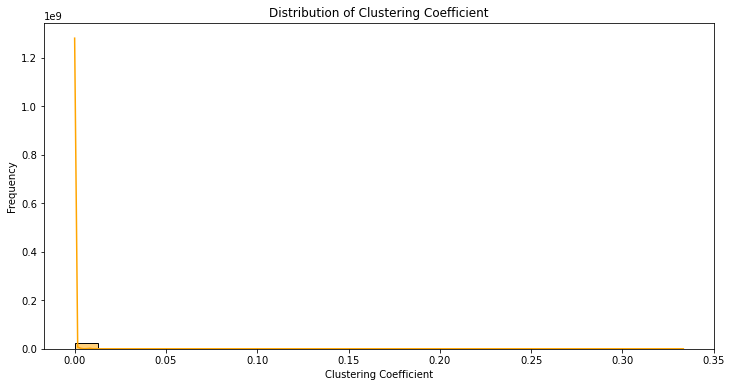

In [38]:
# Visualization of CONNECTED_ACCOUNTS
plt.figure(figsize=(12, 6))
sns.histplot(data['CONNECTED_ACCOUNTS'], kde=True, color='purple')
plt.title('Distribution of Connected Accounts')
plt.xlabel('Number of Connected Accounts')
plt.ylabel('Frequency')
plt.show()

# Visualization of CLUSTERING_COEFFICIENT
plt.figure(figsize=(12, 6))
sns.histplot(data['CLUSTERING_COEFFICIENT'], kde=True, color='orange')
plt.title('Distribution of Clustering Coefficient')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Frequency')
plt.show()

### Standardization

In [46]:
data

,SENDER_ACCOUNT_ID,RECEIVER_ACCOUNT_ID,INIT_BALANCE,TX_BEHAVIOR_ID,TX_AMOUNT,TIMESTAMP,IS_FRAUD,ALERT_ID,ALERT_TYPE_cycle,ALERT_TYPE_fan_in,...,FREQUENCY,MONETARY,KAPPA,LOC,SCALE,IS_ATYPICAL,median,mad,CONNECTED_ACCOUNTS,CLUSTERING_COEFFICIENT
0,0,17405,-0.182066,1,-0.047602,1,0,-1,0,0,...,-0.915242,0.861691,NaN,NaN,NaN,False,NaN,NaN,-1.024683,-0.10035
1,0,17405,-0.182066,1,-0.047602,30,0,-1,0,0,...,-0.915242,0.861691,NaN,NaN,NaN,False,NaN,NaN,-1.024683,-0.10035
2,0,17405,-0.182066,1,-0.047602,37,0,-1,0,0,...,-0.915242,0.861691,NaN,NaN,NaN,False,NaN,NaN,-1.024683,-0.10035
3,0,17405,-0.182066,1,-0.047602,47,0,-1,0,0,...,-0.915242,0.861691,NaN,NaN,NaN,False,NaN,NaN,-1.024683,-0.10035
4,0,17405,-0.182066,1,-0.047602,49,0,-1,0,0,...,-0.915242,0.861691,NaN,NaN,NaN,False,NaN,NaN,-1.024683,-0.10035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23342271,99999,71940,1.374863,5,-0.046779,194,0,-1,0,0,...,-0.804067,0.756575,NaN,NaN,NaN,False,-0.03677,-0.047371,-0.923622,-0.10035
23342272,99999,92113,1.374863,5,-0.046779,194,0,-1,0,0,...,-0.804067,0.756575,NaN,NaN,NaN,False,-0.03677,-0.047371,-0.923622,-0.10035
23342273,99999,18923,1.374863,5,-0.046779,194,0,-1,0,0,...,-0.804067,0.756575,NaN,NaN,NaN,False,-0.03677,-0.047371,-0.923622,-0.10035
23342274,99999,45349,1.374863,5,-0.046779,194,0,-1,0,0,...,-0.804067,0.756575,NaN,NaN,NaN,False,-0.03677,-0.047371,-0.923622,-0.10035


In [ ]:
# Replace infinities with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the mean of the corresponding column
data.fillna(data.mean(), inplace=True)

In [40]:
data.dtypes

SENDER_ACCOUNT_ID           int64
RECEIVER_ACCOUNT_ID         int64
INIT_BALANCE              float64
TX_BEHAVIOR_ID              int64
TX_AMOUNT                 float64
TIMESTAMP                   int64
IS_FRAUD                    int64
ALERT_ID                    int64
ALERT_TYPE_cycle            int64
ALERT_TYPE_fan_in           int64
RECENCY                   float64
FREQUENCY                   int64
MONETARY                  float64
KAPPA                     float64
LOC                       float64
SCALE                     float64
IS_ATYPICAL                  bool
median                    float64
mad                       float64
CONNECTED_ACCOUNTS          int64
CLUSTERING_COEFFICIENT    float64
dtype: object

In [43]:
from sklearn.preprocessing import StandardScaler

#olumns to standardize
columns_to_standardize = [
    'INIT_BALANCE', 
    'TX_AMOUNT', 
    'RECENCY', 
    'FREQUENCY', 
    'MONETARY', 
    'KAPPA', 
    'LOC', 
    'SCALE', 
    'median', 
    'mad', 
    'CONNECTED_ACCOUNTS', 
    'CLUSTERING_COEFFICIENT'
]

scaler = StandardScaler()
data[columns_to_standardize] = scaler.fit_transform(data[columns_to_standardize])

In [44]:
data

,SENDER_ACCOUNT_ID,RECEIVER_ACCOUNT_ID,INIT_BALANCE,TX_BEHAVIOR_ID,TX_AMOUNT,TIMESTAMP,IS_FRAUD,ALERT_ID,ALERT_TYPE_cycle,ALERT_TYPE_fan_in,...,FREQUENCY,MONETARY,KAPPA,LOC,SCALE,IS_ATYPICAL,median,mad,CONNECTED_ACCOUNTS,CLUSTERING_COEFFICIENT
0,0,17405,-0.182066,1,-0.047602,1,0,-1,0,0,...,-0.915242,0.861691,NaN,NaN,NaN,False,NaN,NaN,-1.024683,-0.10035
1,0,17405,-0.182066,1,-0.047602,30,0,-1,0,0,...,-0.915242,0.861691,NaN,NaN,NaN,False,NaN,NaN,-1.024683,-0.10035
2,0,17405,-0.182066,1,-0.047602,37,0,-1,0,0,...,-0.915242,0.861691,NaN,NaN,NaN,False,NaN,NaN,-1.024683,-0.10035
3,0,17405,-0.182066,1,-0.047602,47,0,-1,0,0,...,-0.915242,0.861691,NaN,NaN,NaN,False,NaN,NaN,-1.024683,-0.10035
4,0,17405,-0.182066,1,-0.047602,49,0,-1,0,0,...,-0.915242,0.861691,NaN,NaN,NaN,False,NaN,NaN,-1.024683,-0.10035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23342271,99999,71940,1.374863,5,-0.046779,194,0,-1,0,0,...,-0.804067,0.756575,NaN,NaN,NaN,False,-0.03677,-0.047371,-0.923622,-0.10035
23342272,99999,92113,1.374863,5,-0.046779,194,0,-1,0,0,...,-0.804067,0.756575,NaN,NaN,NaN,False,-0.03677,-0.047371,-0.923622,-0.10035
23342273,99999,18923,1.374863,5,-0.046779,194,0,-1,0,0,...,-0.804067,0.756575,NaN,NaN,NaN,False,-0.03677,-0.047371,-0.923622,-0.10035
23342274,99999,45349,1.374863,5,-0.046779,194,0,-1,0,0,...,-0.804067,0.756575,NaN,NaN,NaN,False,-0.03677,-0.047371,-0.923622,-0.10035


### Principal Component Analysis

In [ ]:
# Replace infinities with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the mean of the corresponding column
data.fillna(data.mean(), inplace=True)

In [45]:
from sklearn.decomposition import PCA

features_for_pca = data.drop(columns=[
    'SENDER_ACCOUNT_ID', 
    'RECEIVER_ACCOUNT_ID', 
    'IS_FRAUD', 
    'ALERT_ID', 
    'ALERT_TYPE_cycle', 
    'ALERT_TYPE_fan_in', 
    'IS_ATYPICAL'
])

pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_for_pca)

#principal components to the DataFrame
data['PC1'] = principal_components[:, 0]
data['PC2'] = principal_components[:, 1]

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# Scatter plot of the first two principal components
plt.figure(figsize=(12, 6))
sns.scatterplot(x='PC1', y='PC2', hue='IS_FRAUD', data=data, palette='coolwarm')
plt.title('PCA of Engineered Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Fraudulent Status', labels=['Non-Fraudulent', 'Fraudulent'])
plt.show()

In [ ]:
data.to_csv('processed_data.csv', index=False)